# UNet Polyp Segmentation

Team 13: James Medel, Shreya Hunur, Sparsha Ramakrishna, Jay Bharadva, Priyank Jagad

May 12, 2022

In [1]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score, FScore

Segmentation Models: using `keras` framework.


In [2]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import load_model
import h5py
from tensorflow.keras import __version__ as keras_version
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Lambda, Cropping2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D

In [3]:
import os
import csv
import cv2
import sys
import glob
import random
import collections
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn import model_selection

import xml.etree.ElementTree as ET

In [4]:
def get_filepaths(basepath, remove_ext=False):
    files = []
    filenames = []
    for filename in os.listdir(basepath):
#         print("filename =", filename)
        if remove_ext is True:
            file_name, file_ext = filename.split(".")
#             print("file_name =", file_name)
#             print("file_ext =", file_ext)
            filepath = os.path.join(basepath, file_name)
            files.append(filepath)
            filenames.append(file_name)
        else:
            filepath = os.path.join(basepath, filename)
            files.append(filepath)
            filenames.append(filename)
    return files, filenames
    
def get_filepaths_videonum_dirs_xy(X_basepath, y_basepath):
    videonum_X_filepaths = []
    videonum_X_filenames = []
    videonum_y_filepaths = []
    videonum_y_filenames = []
    for videonum_X_dir, videonum_y_dir in zip(os.listdir(X_basepath), os.listdir(y_basepath)):
        videonum_X_dirpath = os.path.join(X_basepath, videonum_X_dir)
        videonum_y_dirpath = os.path.join(y_basepath, videonum_y_dir)
        videonum_y_dirfilepaths_tmp = []
        videonum_y_dirfilenames_tmp = []
        videonum_X_dirfilepaths, videonum_X_dirfilenames = get_filepaths(videonum_X_dirpath, remove_ext=True)
        videonum_y_dirfilepaths, videonum_y_dirfilenames = get_filepaths(videonum_y_dirpath, remove_ext=True)
#         print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#         print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        if len(videonum_X_dirfilenames) != len(videonum_y_dirfilenames):
            for y_i in range(len(videonum_y_dirfilenames)):
                if videonum_y_dirfilenames[y_i] in videonum_X_dirfilenames:
#                     print("videonum_y_dirfilenames[y_i] =", videonum_y_dirfilenames[y_i])
#                     print("is in videonum_X_dirfilenames = ", videonum_X_dirfilenames)
                    videonum_y_dirfilenames_tmp.append(videonum_y_dirfilenames[y_i] + ".xml")
                    videonum_y_dirfilepaths_tmp.append(videonum_y_dirfilepaths[y_i] + ".xml")
            videonum_y_filepaths.extend(videonum_y_dirfilepaths_tmp)
            videonum_y_filenames.extend(videonum_y_dirfilenames_tmp)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames_tmp) =", len(videonum_y_dirfilenames_tmp))
        else:
            videonum_y_dirfilepaths = [filepath + ".xml" for filepath in videonum_y_dirfilepaths]
            videonum_y_dirfilenames = [filename + ".xml" for filename in videonum_y_dirfilenames]
            videonum_y_filepaths.extend(videonum_y_dirfilepaths)
            videonum_y_filenames.extend(videonum_y_dirfilenames)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        videonum_X_dirfilepaths = [filepath + ".jpg" for filepath in videonum_X_dirfilepaths]
        videonum_X_dirfilenames = [filename + ".jpg" for filename in videonum_X_dirfilenames]
        videonum_X_filepaths.extend(videonum_X_dirfilepaths)
        videonum_X_filenames.extend(videonum_X_dirfilenames)
    return videonum_X_filepaths, videonum_X_filenames, videonum_y_filepaths, videonum_y_filenames
    
def read_img(img_path, flag = cv2.IMREAD_COLOR):
    # (height, width, 3)
    image = cv2.imread(img_path, flag)
    return image

def get_xml_label_names(xml_files):
    label_names = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_polyp_name = train_y_object.find("name").text
        else:
            train_y_polyp_name = "Not Specified"
        label_names.append(train_y_polyp_name)
    return label_names

def get_xml_boundboxes(xml_files):
    bound_boxes = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_bndbox = train_y_object.find("bndbox")
            train_y_bndbox_xmin = train_y_bndbox.find("xmin").text
            train_y_bndbox_ymin = train_y_bndbox.find("ymin").text
            train_y_bndbox_xmax = train_y_bndbox.find("xmax").text
            train_y_bndbox_ymax = train_y_bndbox.find("ymax").text
            bound_box_tuple = (train_y_bndbox_xmin, train_y_bndbox_ymin, train_y_bndbox_xmax, train_y_bndbox_ymax)
        else:
            bound_box_tuple = False
        bound_boxes.append(
            bound_box_tuple
        )
    return bound_boxes

# normalizes image pixel values betwen -0.5 and 0.5
def normalize_images(images):
    norm_images = []
    for image in tqdm(images):
        norm_img = (image/255.0) - 0.5
        norm_images.append(norm_img)
    return norm_images

def normalize_image(image):
    norm_img = (image/255.0) - 0.5
    return norm_img

def resize_image(image, size):
    resized_image = cv2.resize(image, (size, size))
    return resize_image
    
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_images(image_group, size, flag = cv2.IMREAD_COLOR):
    images = []
    for image_path in tqdm(image_group):
        image = read_img(image_path, flag)
        resized_img = cv2.resize(image, (size, size))
        images.append(resized_img)
    return images

def remove_non_labeled_polyps(img_filepaths, img_filenames, polyp_names):
    cln_X_img_filepaths = []
    cln_X_img_filenames = []
    cln_y_polyp_names = []
    for img_filepath, img_filename, label in zip(img_filepaths, img_filenames, polyp_names):
        if label != "Not Specified":
            cln_X_img_filepaths.append(img_filepath)
            cln_X_img_filenames.append(img_filename)
            cln_y_polyp_names.append(label)
            
    return cln_X_img_filepaths, cln_X_img_filenames, cln_y_polyp_names

def create_image_label_groups(image_paths, image_labels, batch_size=32):
    # Divide image paths and image labels into groups of BATCH_SIZE
    image_groups = list()
    label_groups = list()
    
    for idx in range(0, len(image_paths), batch_size):
        image_batch = list()
        for index in range(idx, idx + batch_size):
            image_batch.append(image_paths[index % len(image_paths)])
        image_groups.append(image_batch)
            
    for idx in range(0, len(image_labels), batch_size):
        for index in range(idx, idx + batch_size):
            label_groups.append(image_labels[index % len(image_labels)])
    
    return image_groups, label_groups
    
def plot_sample(X, y, index):
    plt.figure(figsize = (30,4))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])
    
def save_img(self, dst_path, filename, dst_img):
    """
        Save gradient thresholded image using OpenCV
    """
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)

    plt.imsave(dst_path + filename, dst_img, cmap="gray")

def visualize(self, src_title, orig_img, dst_title, binary_img):
    """
        Visualize gradient thresholded image
    """
    img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title(src_title, fontsize=50)
    ax2.imshow(binary_img, cmap="gray")
    ax2.set_title(dst_title, fontsize=50)
    plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

In [5]:
sm.set_framework('tf.keras')

## Load Training Set Images & Masked Labels

In [6]:
train_y_basepath = "PolypsSet/train2019/Annotation"
file_type = ".xml"
train_y_filepaths, train_y_filenames = get_filepaths(train_y_basepath, file_type)

In [7]:
train_X_basepath = "PolypsSet/train2019/Image"
file_type = ".jpg"
train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)

In [8]:
train_y_polyp_names = get_xml_label_names(train_y_filepaths[:1000])

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 207.70it/s]


C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Extracted Polyp Name Labels')

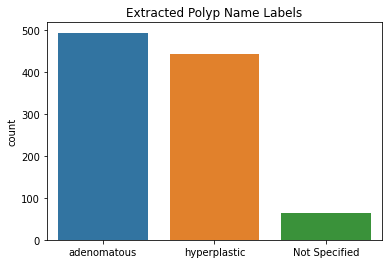

In [9]:
plt.figure()
sns.countplot(train_y_polyp_names)
plt.title("Extracted Polyp Name Labels")

In [10]:
cln_train_X_filepaths, cln_train_X_filenames, cln_train_y_polyp_names = remove_non_labeled_polyps(
    train_X_filepaths[:1000], train_X_filenames[:1000], train_y_polyp_names)

In [11]:
len(cln_train_X_filenames)

937

C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Extracted Polyp Name Labels')

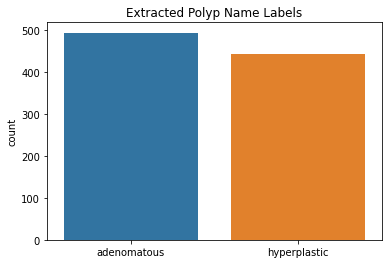

In [12]:
plt.figure()
sns.countplot(cln_train_y_polyp_names)
plt.title("Extracted Polyp Name Labels")

In [13]:
len(cln_train_X_filepaths)

937

In [14]:
len(cln_train_y_polyp_names)

937

In [15]:
# read BGR cause of OpenCV: load 100 images
train_X_images = get_images(cln_train_X_filepaths, 192)

100%|███████████████████████████████████████████████████████████████████| 937/937 [00:09<00:00, 97.33it/s]


In [16]:
X_train = np.array(train_X_images)

In [17]:
X_train.shape

(937, 192, 192, 3)

In [18]:
X_train = X_train / 255

In [19]:
label_enc = LabelEncoder()
train_y = label_enc.fit_transform(cln_train_y_polyp_names)
classes = ['adenomatous', 'hyperplastic']

C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Label Encoded Polyps (0=Adenomatous; 1=Hyperplastic)')

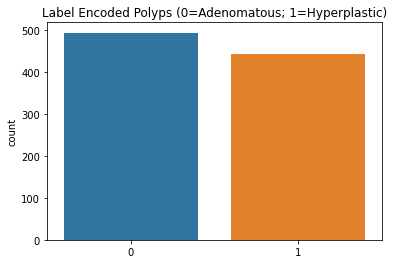

In [20]:
plt.figure()
sns.countplot(train_y)
plt.title("Label Encoded Polyps (0=Adenomatous; 1=Hyperplastic)")

In [ ]:
# np.save("polyp_y_train_27048.npy", train_y)

In [ ]:
# np.save("polyp_x_train_27048.npy", X_train)

## Feature Engineer Polyp Masked Labels For Training

Use color transforms, gradients, etc. to create a polyp masked threshold binary image per polyp image. After comparing masking for 2 images. I am going to try a labeling tool instead and label 100 to 1000 images.

Here is the link I am going to try, they have built a labeling tool using matplotlib for masking images as labels that will be used for training UNet:

- [How we built an easy-to-use image segmentation tool with transfer learning](https://towardsdatascience.com/how-we-built-an-easy-to-use-image-segmentation-tool-with-transfer-learning-546efb6ae98)

Check out **GitHub Repo: [mpl-interations](https://github.com/ianhi/mpl-interactions)**

Check out **GitHub Repo: [matplotlib/ipympl](https://github.com/matplotlib/ipympl#install-the-jupyterlab-extension)**

Check out **[mpl-interactions Tutorial: Image Segmentation Label Tool](https://mpl-interactions.readthedocs.io/en/latest/examples/image-segmentation.html)**

For using custom Matplotlib Image Segmenter tool in Jupyter Notebook, you can install it with pip:

~~~bash
pip install mpl_interactions["jupyter"] # will install necessary deps for using in jupyter

# for use outside jupyter
pip install mpl_interactions

# install ipympl; they recommend installing jupyterlab >= 3
pip install ipympl

# recommended
conda install -c conda-forge jupyterlab

# need to install jupyter labextension
conda install -c conda-forge nodejs
jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-matplotlib
~~~

## Draw Masked Polyp Labels with Matplotlib's Image Segmenter

Naming convention will be polyp type followed by the original image file number.

In [ ]:
%matplotlib ipympl
import matplotlib.cbook as cbook

from mpl_interactions import image_segmenter

In [44]:
# need to aim for 200 manually masked labels
# last one: 99
polyp_img_num = 99

In [ ]:
train_X_img_filename = cln_train_X_filenames[polyp_img_num]
print(train_X_img_filename)

In [ ]:
train_y_polyp_name = cln_train_y_polyp_names[polyp_img_num]
print(train_y_polyp_name)

In [ ]:
# yellow for polyp
train_X_img_bgr = train_X_images[polyp_img_num]
train_X_img_rgb = cv2.cvtColor(train_X_img_bgr, cv2.COLOR_BGR2RGB)
segmenter = image_segmenter(train_X_img_rgb, 
                            mask_colors="yellow", 
                            mask_alpha=0.75,
                            figsize=(4, 4))
plt.axis("off")
display(segmenter)

In [ ]:
plt.figure()
plt.imshow(segmenter.mask)

In [ ]:
# I will get a saved img 192x192 since earlier I resized img to 192x192. Factor of 32 for obj detect
plt.imsave("PolypsSet/train2019/RGBSegLabel/" + train_X_img_filename, 
           segmenter.mask)

In [ ]:
plt.figure()
plt.imshow(segmenter.mask, cmap = "gray")

In [ ]:
plt.imsave("PolypsSet/train2019/GraySegLabel/" + train_X_img_filename, 
           segmenter.mask, cmap = "gray")

## Loading Masked Labels from Feature Engineering

In [21]:
train_masks_basepath = "PolypsSet/train2019/GraySegLabel"
file_type = ".jpg"
train_masks_filepaths, train_masks_filenames = get_filepaths(train_masks_basepath, file_type)

In [22]:
train_mask_images = get_images(train_masks_filepaths, 192, flag = cv2.IMREAD_GRAYSCALE)
y_train_masks = np.array(train_mask_images)
y_train_masks = y_train_masks/255

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 625.39it/s]


## Data Augment Images

In [23]:
import albumentations as A

In [24]:
images_to_generate = 2000

In [25]:
img_augmented_path="PolypsSet/train2019/aug_seg_img_192/"
msk_augmented_path="PolypsSet/train2019/aug_seg_gray_mask_192/" # path to gray seg masks

In [26]:
aug = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=1),
    A.Transpose(p=1),
    A.GridDistortion(p=1)
])

In [27]:
i=1

In [28]:
# augmenting on top of 100 images and 100 masked images gen 2000
# then save them in a folder
while i <= images_to_generate:
    number = random.randint(0, len(train_X_images[:100])-1)
    orig_image = train_X_images[number]
    orig_mask = train_mask_images[number]
    
    augmented = aug(image = orig_image, mask = orig_mask)
    transformed_image = augmented["image"]
    transformed_mask = augmented["mask"]
    
    # due to opencv being bgr, so go rgb
    transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
    
    new_image_path = "%s/aug_image_%s.jpg" %(img_augmented_path, i)
    new_mask_path = "%s/aug_mask_%s.jpg" %(msk_augmented_path, i)
    
    plt.imsave(new_image_path, transformed_image)
    plt.imsave(new_mask_path, transformed_mask, cmap="gray")
    i = i+1

## Loading Validation Set

In [ ]:
valid_X_basepath = "PolypsSet/val2019/Image"
valid_y_basepath = "PolypsSet/val2019/Annotation"

# Problem is that the valid set has more labels than there are images, so need to make them equal
valid_X_filepaths, valid_X_filenames, valid_y_filepaths, valid_y_filenames= get_filepaths_videonum_dirs_xy(valid_X_basepath, valid_y_basepath)

In [ ]:
valid_y_polyp_names = get_xml_label_names(valid_y_filepaths)

In [ ]:
sns.countplot(valid_y_polyp_names)

In [ ]:
cln_valid_X_filepaths, cln_valid_y_polyp_names = remove_non_labeled_polyps(
    valid_X_filepaths, valid_y_polyp_names)

In [ ]:
sns.countplot(cln_valid_y_polyp_names)

In [ ]:
valid_X_images = get_images(cln_valid_X_filepaths, 192)

In [ ]:
X_valid = np.array(valid_X_images)

In [ ]:
X_valid = X_valid / 255

In [ ]:
valid_y = label_enc.fit_transform(cln_valid_y_polyp_names)

In [ ]:
# np.save("polyp_x_valid_4214.npy", X_valid)

In [ ]:
# np.save("polyp_y_valid_4214.npy", valid_y)

## Loading Testing Set

In [53]:
test_X_basepath = "PolypsSet/test2019/Image"
test_y_basepath = "PolypsSet/test2019/Annotation"

# Potential Problem is that the test set has more labels than there are images, so need to make them equal
test_X_filepaths, test_X_filenames, test_y_filepaths, test_y_filenames= get_filepaths_videonum_dirs_xy(test_X_basepath, test_y_basepath)

In [54]:
test_y_polyp_names = get_xml_label_names(test_y_filepaths)

100%|████████████████████████████████████████████████████████████████| 4872/4872 [00:26<00:00, 187.05it/s]


C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

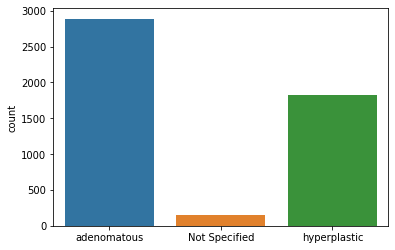

In [55]:
sns.countplot(test_y_polyp_names)

In [56]:
cln_test_X_filepaths, cln_test_X_filenames, cln_test_y_polyp_names = remove_non_labeled_polyps(
    test_X_filepaths, test_X_filenames, test_y_polyp_names)

In [57]:
test_X_images = get_images(cln_test_X_filepaths, 192)

100%|█████████████████████████████████████████████████████████████████| 4719/4719 [00:48<00:00, 97.56it/s]


In [ ]:
X_test = np.array(test_X_images)

In [ ]:
X_test = X_test / 255

In [ ]:
sns.countplot(cln_test_y_polyp_names)

In [ ]:
test_y = label_enc.fit_transform(cln_test_y_polyp_names)

In [ ]:
len(test_y[:100])

In [ ]:
# np.save("polyp_y_test_4719.npy", test_y)

In [ ]:
# np.save("polyp_x_test_4719.npy", X_test)

## Build UNet

In [29]:
aug_train_X_basepath = "PolypsSet/train2019/aug_seg_img_192"
file_type = ".jpg"
aug_train_X_filepaths, aug_train_X_filenames = get_filepaths(aug_train_X_basepath, file_type)

In [30]:
aug_train_X_images = get_images(aug_train_X_filepaths, 192)

100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 224.48it/s]


In [31]:
aug_X_train = np.array(aug_train_X_images)

In [32]:
aug_X_train = aug_X_train / 255

In [33]:
aug_train_masks_basepath = "PolypsSet/train2019/aug_seg_gray_mask_192"
file_type = ".jpg"
aug_train_masks_filepaths, aug_train_masks_filenames = get_filepaths(aug_train_masks_basepath, file_type)

In [34]:
aug_train_mask_images = get_images(aug_train_masks_filepaths, 192, flag = cv2.IMREAD_GRAYSCALE)
aug_y_train_masks = np.array(aug_train_mask_images)
aug_y_train_masks = aug_y_train_masks/255

100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 264.29it/s]


In [35]:
#expand y by 1 dimension adding a 1 to the last position
aug_y_train_masks = np.expand_dims(aug_y_train_masks, axis=3)

In [36]:
aug_y_train_masks.shape

(2000, 192, 192, 1)

In [37]:
aug_X_train.shape

(2000, 192, 192, 3)

In [38]:
X_train_polyp, X_test_polyp, y_train_polyp, y_test_polyp = model_selection.train_test_split(
    aug_X_train, aug_y_train_masks, test_size=0.2, random_state=42
)

In [39]:
len(y_train_polyp)

1600

In [40]:
len(y_test_polyp)

400

In [41]:
# https://segmentation-models.readthedocs.io/en/latest/api.html
# Can take any img size, but must be divisible by factor of 32
model = Unet(backbone_name='resnet34', input_shape=(None,None,3), 
             classes=1, activation="sigmoid", encoder_weights='imagenet')

In [42]:
# mean squared error since this is a pixel classification
# most common metrics for semantic segmentation: pixel accuracy, intersection over union (IOU),
# dice coefficient (f1 sccore)
# 1. High pixel accuracy doesnt always imply superior segmentation ability. This issue is class imbalance
# 2. IoU Score one of most commonly used metrics and its extremely effective: 0 means no overlap  & 1 means perfect
# overlapping segmentation
# 3. Dice Coefficient f1-score range 0 to 1, 1 signifies greatest similarity between predicted and truth; weighted average
# of precision and recall where f-score reaches best value at 1 and worst at 0.
model.compile('Adam', loss=bce_jaccard_loss, metrics=["accuracy", FScore(), iou_score])

In [43]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [44]:
history = model.fit(
    x=X_train_polyp,
    y=y_train_polyp,
    batch_size=8,
    epochs=6,
    validation_split=0.2,
    verbose=1
)

Epoch 1/6
160/160 [==============================] - 32s 99ms/step - loss: 1.1208 - accuracy: 0.8676 - f1-score: 0.2518 - iou_score: 0.1469 - val_loss: 1.3416 - val_accuracy: 0.6943 - val_f1-score: 0.2252 - val_iou_score: 0.1284
Epoch 2/6
160/160 [==============================] - 15s 92ms/step - loss: 0.9521 - accuracy: 0.9001 - f1-score: 0.3825 - iou_score: 0.2393 - val_loss: 1.3115 - val_accuracy: 0.9053 - val_f1-score: 0.0220 - val_iou_score: 0.0111
Epoch 3/6
160/160 [==============================] - 15s 92ms/step - loss: 0.8077 - accuracy: 0.9188 - f1-score: 0.5159 - iou_score: 0.3532 - val_loss: 1.4980 - val_accuracy: 0.9053 - val_f1-score: 0.0019 - val_iou_score: 9.4525e-04
Epoch 4/6
160/160 [==============================] - 15s 94ms/step - loss: 0.6799 - accuracy: 0.9298 - f1-score: 0.6246 - iou_score: 0.4596 - val_loss: 1.6252 - val_accuracy: 0.9053 - val_f1-score: 3.2194e-04 - val_iou_score: 1.6099e-04
Epoch 5/6
160/160 [==============================] - 15s 95ms/step - los

In [45]:
# len(X_test[:100])
X_test_polyp.shape

(400, 192, 192, 3)

In [46]:
# len(test_y[:100])
y_test_polyp.shape

(400, 192, 192, 1)

In [47]:
accuracy = model.evaluate(X_test_polyp, y_test_polyp)

13/13 [==============================] - 4s 126ms/step - loss: 0.8615 - accuracy: 0.9231 - f1-score: 0.5433 - iou_score: 0.3751


In [48]:
# only trained on 20 polyp masked images so far
model.save("polyp_unet_bin_seg.h5")

C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Plot Train vs Valid Loss Curves After Training UNet

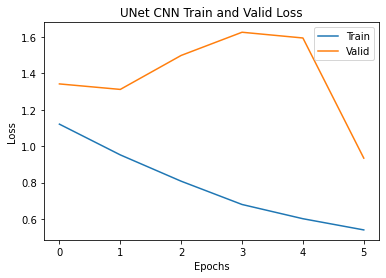

In [49]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("UNet CNN Train and Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Plot Train vs Valid IOU Score Curves After Training UNet

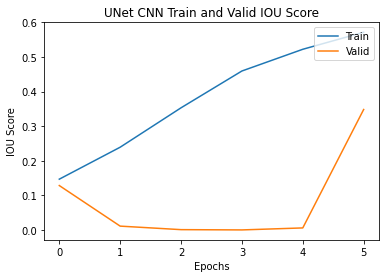

In [50]:
plt.figure()
plt.plot(history.history["iou_score"])
plt.plot(history.history["val_iou_score"])
plt.title("UNet CNN Train and Valid IOU Score")
plt.xlabel("Epochs")
plt.ylabel("IOU Score")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## Plot Train vs Valid F1 Score Curves After Training UNet

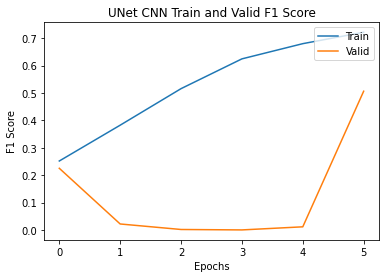

In [51]:
plt.figure()
plt.plot(history.history["f1-score"])
plt.plot(history.history["val_f1-score"])
plt.title("UNet CNN Train and Valid F1 Score")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend(["Train", "Valid"], loc="upper right")
plt.show()

## UNet Predict Polyp Segmentation on Test Image

In [ ]:
# load model if already have unet trained model saved
# model = load_model("polyp_unet_bin_seg.h5")

PolypsSet/test2019/Image\1\10.jpg


Text(0.5, 1.0, 'Test Polyp Img Before UNet Segmentation')

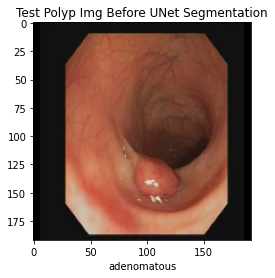

In [103]:
# use one of the test images
print(cln_test_X_filepaths[1])
test_img_1_rgb = cv2.cvtColor(test_X_images[1], cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(test_img_1_rgb)
plt.xlabel(classes[0])
plt.title("Test Polyp Img Before UNet Segmentation")
# plt.show()

Text(0.5, 1.0, 'Test Polyp Img Before UNet Segmentation')

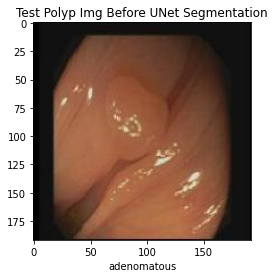

In [131]:
test_img_1_rgb = cv2.cvtColor(aug_train_X_images[1], cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(test_img_1_rgb)
plt.xlabel(classes[0])
plt.title("Test Polyp Img Before UNet Segmentation")
# plt.show()

In [132]:
test_img_1_rgb.shape

(192, 192, 3)

In [133]:
# expand test img1 dimension adding 1 at front
test_img_1_rgb = np.expand_dims(test_img_1_rgb, axis=0)

In [134]:
test_img_1_rgb.shape

(1, 192, 192, 3)

In [135]:
polyp_seg_pred = model.predict(test_img_1_rgb)

In [136]:
polyp_seg_pred.shape

(1, 192, 192, 1)

In [137]:
polyp_seg_pred_img = polyp_seg_pred.reshape(y_train_masks[0].shape)

In [138]:
polyp_seg_pred_img.shape

(192, 192)

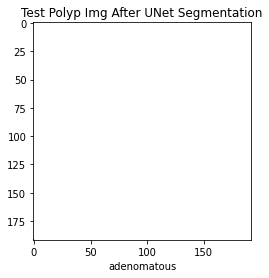

In [139]:
# we can see unet segmentation doesnt capture the polyp. We need more training masked labels
plt.figure()
plt.imshow(polyp_seg_pred_img, cmap="gray")
plt.xlabel(classes[0])
plt.title("Test Polyp Img After UNet Segmentation")
# plt.imsave("unet/seg_pred_images/test0_segmented_v3.jpg", polyp_seg_pred_img, cmap = "gray")
plt.savefig("unet/trained_100/seg_pred_images/test0_segmented.jpg")

## References

- [Image Segmentation: Kumaravel Subramaniam Tamilselvan and Govindasamy Murugesan](https://cdn.intechopen.com/pdfs/60741.pdf)
- [Metrics to Evaluate your Semantic Segmentation Model](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)